![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import collections

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [6]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [8]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [9]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [11]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [13]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
37242,id_7460,London,['Seafood'],7469.0,NaN,10.0,"[['Best Chippie!', 'Excellent service'], ['04/...",/Restaurant_Review-g186338-d4910213-Reviews-Se...,d4910213,1,5.0
29300,id_404,Brussels,"['Italian', 'American']",405.0,$$ - $$$,139.0,"[['Food or food in the box = takeaway', 'Great...",/Restaurant_Review-g188644-d4154250-Reviews-Th...,d4154250,1,4.5
41288,id_1165,Amsterdam,"['Asian', 'Indonesian', 'Vegetarian Friendly',...",1168.0,$$ - $$$,99.0,"[['very tasty food', 'Great pleasure'], ['10/3...",/Restaurant_Review-g188590-d1979290-Reviews-So...,d1979290,1,4.0
25441,id_820,Budapest,"['European', 'Hungarian', 'Italian', 'Pizza', ...",821.0,$$ - $$$,75.0,"[['Love love love this pizza!!', 'Great food, ...",/Restaurant_Review-g274887-d3294104-Reviews-IL...,d3294104,1,4.0
5048,id_5048,Warsaw,"['French', 'Cafe', 'Vegetarian Friendly', 'Veg...",354.0,$$ - $$$,417.0,"[['Must!', 'Tasty French fleur'], ['01/05/2018...",/Restaurant_Review-g274856-d2266605-Reviews-Ch...,d2266605,0,0.0


In [14]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [15]:
# Для примера я возьму столбец Number of Reviews
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')

In [16]:
data['Number_of_Reviews_isNAN']

0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    0
Name: Number_of_Reviews_isNAN, Length: 50000, dtype: uint8

In [17]:
# Далее заполняем пропуски 0, вы можете попробовать заполнением средним или средним по городу и тд...
data['Number of Reviews'].fillna(0, inplace=True)

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [18]:
data.nunique(dropna=False)

Restaurant_id              13094
City                          31
Cuisine Style              10732
Ranking                    12975
Price Range                    4
Number of Reviews           1574
Reviews                    41858
URL_TA                     49963
ID_TA                      49963
sample                         2
Rating                        10
Number_of_Reviews_isNAN        2
dtype: int64

Какие признаки можно считать категориальными?

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.
Не будем сейчас сильно погружаться в эту тематику, давайте посмотрим лучше пример с One-Hot Encoding:
![](https://i.imgur.com/mtimFxh.png)

****

По городам можно найти много интересной информации. Давайте посмотрим, что нам доступно из википедии:

In [19]:
def city_population(x):
    if x == 'Paris':
        x = int(2148327)
    elif x == 'Helsinki':
        x = int(655281)
    elif x == 'Edinburgh':
        x = int(488100)
    elif x == 'London':
        x = int(8908081)
    elif x == 'Bratislava':
        x = int(437725)
    elif x == 'Lisbon':
        x = int(505526)
    elif x == 'Budapest':
        x = int(1752286)
    elif x == 'Stockholm':
        x = int(961609)
    elif x == 'Rome':
        x = int(2870500)
    elif x == 'Milan':
        x = int(1378689)
    elif x == 'Munich':
        x = int(1471508)
    elif x == 'Hamburg':
        x = int(1841179)
    elif x == 'Prague':
        x = int(1301132)
    elif x == 'Vienna':
        x = int(1897491)
    elif x == 'Dublin':
        x = int(1173179)
    elif x == 'Barcelona':
        x = int(1636762)    
    elif x == 'Brussels':
        x = int(179277)
    elif x == 'Madrid':
        x = int(3266126)    
    elif x == 'Oslo':
        x = int(673469)
    elif x == 'Amsterdam':
        x = int(872757)    
    elif x == 'Berlin':
        x = int(3644826)
    elif x == 'Lyon':
        x = int(506615)
    elif x == 'Athens':
        x = int(664046)    
    elif x == 'Warsaw':
        x = int(1790658)
    elif x == 'Oporto':
        x = int(237591)    
    elif x == 'Krakow':
        x = int(779115)
    elif x == 'Copenhagen':
        x = int(615993)    
    elif x == 'Luxembourg':
        x = int(602005)
    elif x == 'Zurich':
        x = int(428737)
    elif x == 'Geneva':
        x = int(200548)
    elif x == 'Ljubljana':
        x = int(284355)
    return x

In [20]:
data['City_population'] = data['City'].apply(city_population)

In [21]:
data.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_isNAN,City_population
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,0,2148327
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,0,655281
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0,488100
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,0,8908081
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,0,437725


In [22]:
# плотность населения
def city_density(x):
    if x == 'Paris':
        x = int(20781)
    elif x == 'Helsinki':
        x = int(3035)
    elif x == 'Edinburgh':
        x = int(1830)
    elif x == 'London':
        x = int(5173)
    elif x == 'Bratislava':
        x = int(1169)
    elif x == 'Lisbon':
        x = int(4883)
    elif x == 'Budapest':
        x = int(3351)
    elif x == 'Stockholm':
        x = int(4800)
    elif x == 'Rome':
        x = int(2232)
    elif x == 'Milan':
        x = int(7700)
    elif x == 'Munich':
        x = int(4500)
    elif x == 'Hamburg':
        x = int(2320)
    elif x == 'Prague':
        x = int(2700)
    elif x == 'Vienna':
        x = int(16000)
    elif x == 'Dublin':
        x = int(4588)
    elif x == 'Barcelona':
        x = int(15779)    
    elif x == 'Brussels':
        x = int(5384)
    elif x == 'Madrid':
        x = int(5390)    
    elif x == 'Oslo':
        x = int(1645)
    elif x == 'Amsterdam':
        x = int(4908)    
    elif x == 'Berlin':
        x = int(3809)
    elif x == 'Lyon':
        x = int(10000)
    elif x == 'Athens':
        x = int(17040)    
    elif x == 'Warsaw':
        x = int(3372)
    elif x == 'Oporto':
        x = int(6900)    
    elif x == 'Krakow':
        x = int(2328)
    elif x == 'Copenhagen':
        x = int(4400)    
    elif x == 'Luxembourg':
        x = int(242)
    elif x == 'Zurich':
        x = int(4700)
    elif x == 'Geneva':
        x = int(12000)
    elif x == 'Ljubljana':
        x = int(1712)
    return x

In [23]:
data['city_density'] = data['City'].apply(city_density)

In [24]:
data.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_isNAN,City_population,city_density
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,0,2148327,20781
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,0,655281,3035
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0,488100,1830
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,0,8908081,5173
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,0,437725,1169


In [25]:
#Создадем новый датафрейм с количеством ресторанов в каждом городе (по данным имеющегося датафрейма) 
df2 = data['City'].value_counts().rename_axis('City').to_frame(name='Rest Count')
#Добавим количество ресторанов в исходный датафрейм
data = data.merge(df2, on='City', how='left')
#Новый ранг - отношение ранга к количеству ресторанов в городе
data['New Rank'] = data['Ranking'] / data['Rest Count']

In [26]:
data.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_isNAN,City_population,city_density,Rest Count,New Rank
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,0,2148327,20781,6108,2.122299
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,0,655281,3035,475,0.223158
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0,488100,1830,745,1.087248
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,0,8908081,5173,7193,0.232031
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,0,437725,1169,380,0.097368


In [27]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 47 columns):
Restaurant_id              50000 non-null object
Cuisine Style              38410 non-null object
Ranking                    50000 non-null float64
Price Range                32639 non-null object
Number of Reviews          50000 non-null float64
Reviews                    49998 non-null object
URL_TA                     50000 non-null object
ID_TA                      50000 non-null object
sample                     50000 non-null int64
Rating                     50000 non-null float64
Number_of_Reviews_isNAN    50000 non-null uint8
City_population            50000 non-null int64
city_density               50000 non-null int64
Rest Count                 50000 non-null int64
New Rank                   50000 non-null float64
City_Amsterdam             50000 non-null uint8
City_Athens                50000 non-null uint8
City_Barcelona             50000 non-null uint8
City_Berlin  

In [29]:
data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
46542,id_789,"['Polish', 'European', 'Central European', 'Ve...",790.0,$$ - $$$,107.0,"[['Great cocktails', 'Great for a drink on a n...",/Restaurant_Review-g274772-d4129958-Reviews-C_...,d4129958,1,3.5,...,0,0,0,0,0,0,0,0,0,0
31405,id_797,NaN,798.0,NaN,15.0,[['Phantastic surprise in the mids of Budapes....,/Restaurant_Review-g274887-d10056355-Reviews-M...,d10056355,1,4.5,...,0,0,0,0,0,0,0,0,0,0
46788,id_679,"['Bar', 'Scottish', 'British', 'Pub']",680.0,$$ - $$$,49.0,"[['I just liked it so much', 'Excellent Bar in...",/Restaurant_Review-g274707-d2101068-Reviews-Wh...,d2101068,1,4.5,...,0,0,0,1,0,0,0,0,0,0
30611,id_2500,NaN,2505.0,NaN,0.0,"[[], []]",/Restaurant_Review-g187331-d9978314-Reviews-Ch...,d9978314,1,3.0,...,0,0,0,0,0,0,0,0,0,0
43988,id_2723,"['Japanese', 'Peruvian', 'Seafood', 'Sushi', '...",2724.0,$$ - $$$,317.0,"[['Worth the trip', 'Molto carino'], ['06/09/2...",/Restaurant_Review-g187791-d10199024-Reviews-C...,d10199024,1,3.5,...,0,0,0,0,1,0,0,0,0,0


#### Возьмем следующий признак "Price Range".

In [30]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3  
*Попробуйте сделать обработку этого признака уже самостоятельно!*

In [31]:
#Заполняем пустые значения колонки Price Range самой распространенной ценовой категорией
data['Price Range'] = data['Price Range'].fillna('$$ - $$$')
#Заменяем значения на числа
data['Price Range'] = data['Price Range'].replace('$', '1')
data['Price Range'] = data['Price Range'].replace('$$ - $$$', '2')
data['Price Range'] = data['Price Range'].replace('$$$$', '3')

> Для некоторых алгоритмов МЛ даже для не категориальных признаков можно применить One-Hot Encoding, и это может улучшить качество модели. Пробуйте разные подходы к кодированию признака - никто не знает заранее, что может взлететь.

### Обработать другие признаки вы должны самостоятельно!
Для обработки других признаков вам возможно придется даже написать свою функцию, а может даже и не одну, но в этом и есть ваша практика в этом модуле!     
Следуя подсказкам в модуле вы сможете более подробно узнать, как сделать эти приобразования.

In [32]:
# Cuisine Style и Dummie
# Создадим признак для ресторанов где тип кухни не упомянут
data['cuisine_isna'] = pd.isna(data['Cuisine Style']).astype('uint8')

In [33]:
#Очистим строки от всего лишнего, включая пробелы и оставим только разделители-запятые
data['Cuisine Style'] = data.apply(lambda x: x['Cuisine Style'].replace('[','').replace(']','').replace("'",'').replace(' ','') 
                                   if type(x['Cuisine Style']) != float else x['Cuisine Style'], axis = 1)

#Разберем признак который представлен строкой, на дамми-переменные по разделителю
styles = data['Cuisine Style'].str.get_dummies(',').sum().sort_values(ascending = False)
styles_drop = [x for x in styles.index if styles[x] < 100] # изначально ограничимся только признаками которые имеют больше 100 ресторанов

#Присоединим получившийся датафрейм новых признаков 
data = data.join(data['Cuisine Style'].str.get_dummies(',').drop(styles_drop, axis = 1), how = 'left')

In [34]:
data.sample()

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,StreetFood,Sushi,Swedish,Swiss,Thai,Turkish,VeganOptions,VegetarianFriendly,Vietnamese,WineBar
39985,id_4109,"European,Czech,EasternEuropean,CentralEuropean",4125.0,2,226.0,"[['Worst restaurant I’ve been to', 'I hate thi...",/Restaurant_Review-g274707-d3732205-Reviews-Re...,d3732205,1,1.5,...,0,0,0,0,0,0,0,0,0,0


Reviews

In [35]:
# посмотрим на содепжимое колонки:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

In [36]:
#Видно, что здесь есть интересующие нас даты
#Добавляем 3 новых столбца: время между последним комментарием в датасете и последнем в ресторане,
#аналогично с предпоследним
#время между комментариями
import datetime as dt
pattern = re.compile('\d{2}/\d{2}/\d{4}')
reviews=[]
for i in data['Reviews']:
    reviews.append(re.findall(pattern, str(i)))
rev=pd.DataFrame(reviews).dropna()
rev.columns=['date1', 'date2']
rev['date1'] = pd.to_datetime(rev['date1']) 
rev['date2'] = pd.to_datetime(rev['date2']) 
rev['dd']=rev['date1']-rev['date2']
data['date1'] = rev['date1'].max() - rev['date1']
data['date1'] = data['date1'].apply(lambda x: x.days)
data['date1'] = data['date1'].fillna(0)
data['date1'] = data['date1'].apply(lambda x: int(x))
data['date2'] = rev['date1'].max() - rev['date2']
data['date2'] = data['date2'].apply(lambda x: x.days)
data['date2'] = data['date2'].fillna(0)
data['date2'] = data['date2'].apply(lambda x: int(x))
data['dd']=data['date2']-data['date1']

![](https://cs10.pikabu.ru/post_img/2018/09/06/11/1536261023140110012.jpg)

In [37]:
data.head()

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,Swiss,Thai,Turkish,VeganOptions,VegetarianFriendly,Vietnamese,WineBar,date1,date2,dd
0,id_0,"Bar,Pub",12963.0,2,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,id_1,"European,Scandinavian,GlutenFreeOptions,Vegeta...",106.0,2,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,0,0,1,1,0,0,83,120,37
2,id_2,VegetarianFriendly,810.0,2,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,0,0,0,1,0,0,60,82,22
3,id_3,"Italian,Mediterranean,European,VegetarianFrien...",1669.0,3,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,0,0,0,0,1,0,0,82,96,14
4,id_4,"Italian,Mediterranean,European,Seafood,Vegetar...",37.0,3,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,0,0,0,0,1,0,0,18,33,15


# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

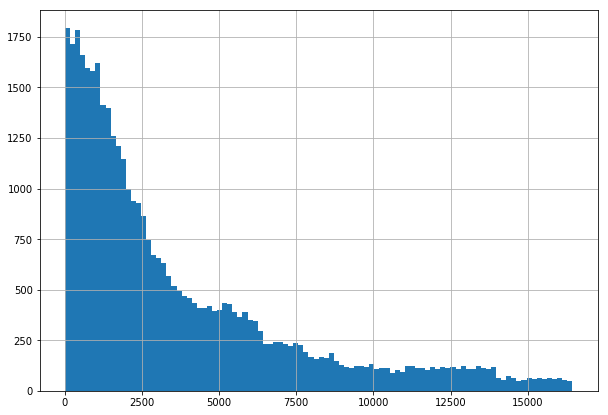

In [38]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

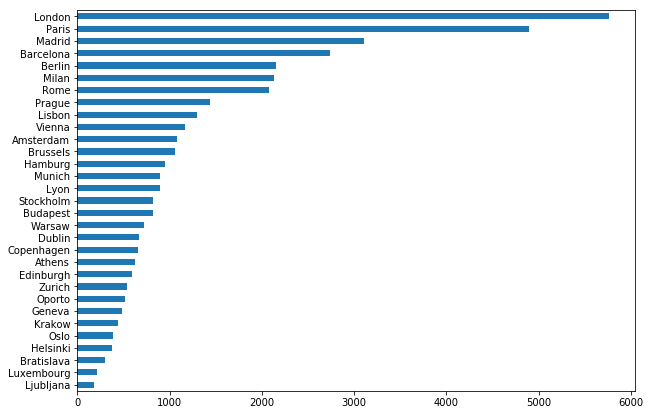

In [39]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

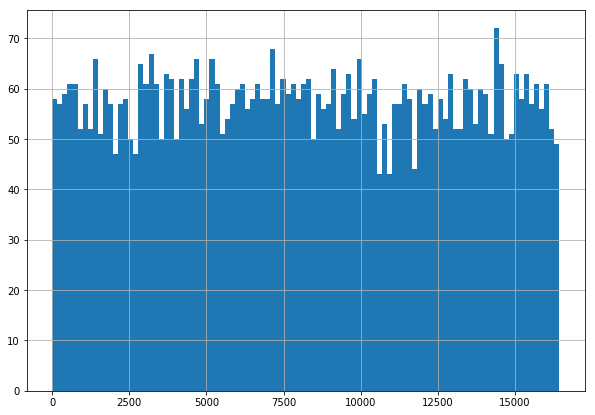

In [40]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

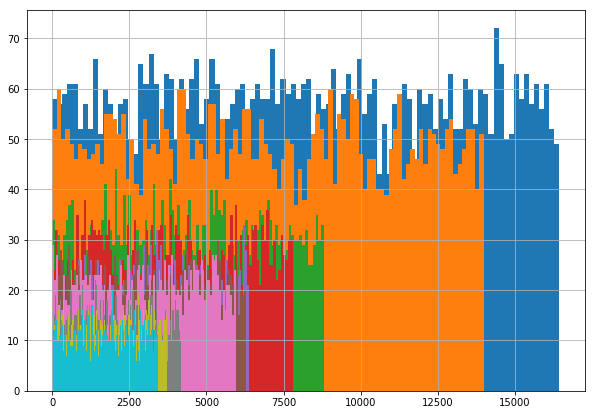

In [41]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


### Посмотрим распределение целевой переменной

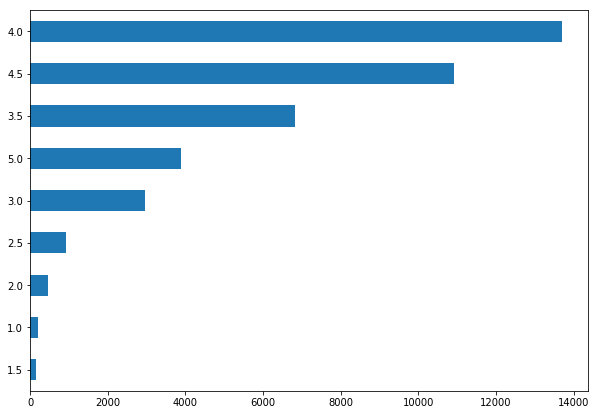

In [42]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

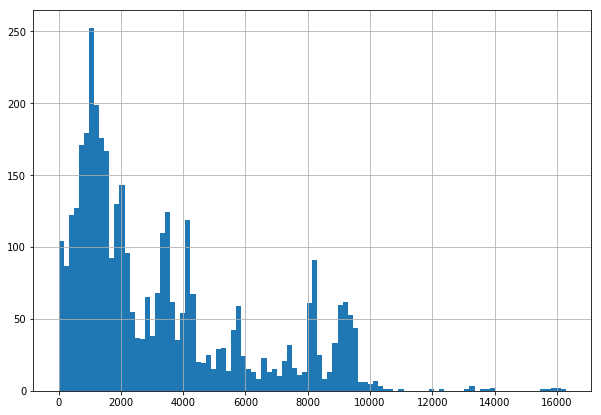

In [43]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

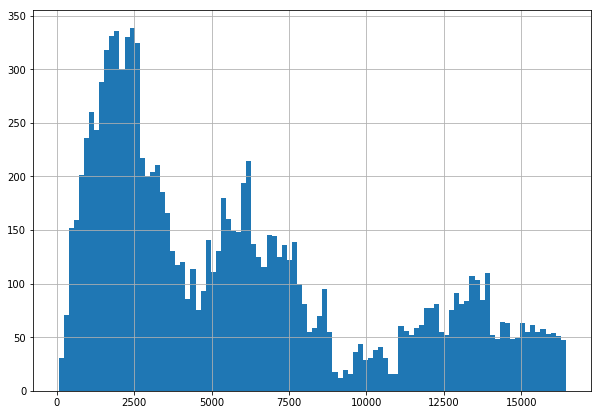

In [44]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

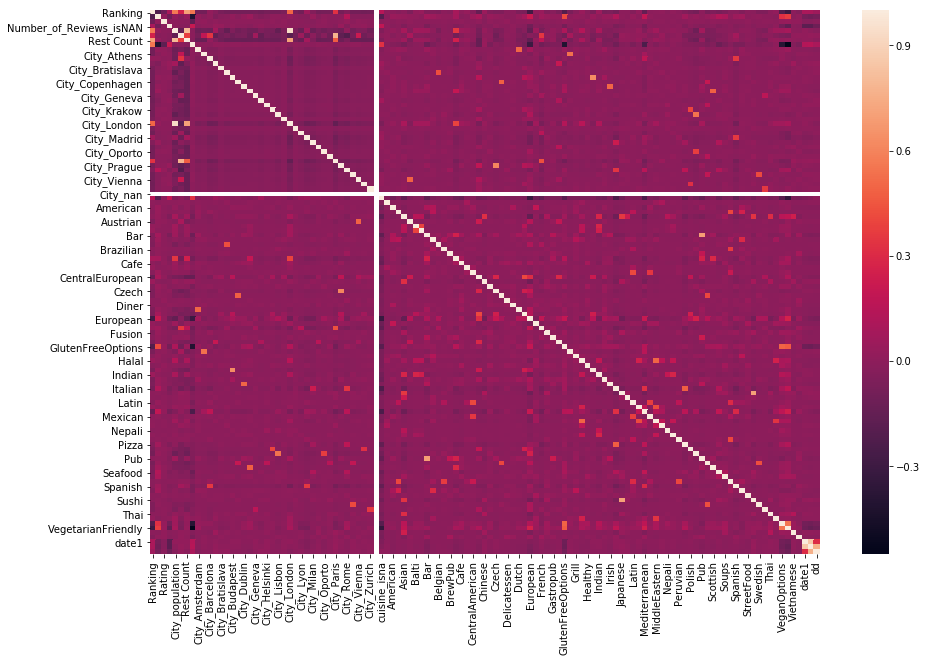

In [45]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# Data Preprocessing


In [46]:
data

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,Swiss,Thai,Turkish,VeganOptions,VegetarianFriendly,Vietnamese,WineBar,date1,date2,dd
0,id_0,"Bar,Pub",12963.0,2,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,id_1,"European,Scandinavian,GlutenFreeOptions,Vegeta...",106.0,2,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,0,0,1,1,0,0,83,120,37
2,id_2,VegetarianFriendly,810.0,2,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,0,0,0,1,0,0,60,82,22
3,id_3,"Italian,Mediterranean,European,VegetarianFrien...",1669.0,3,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,0,0,0,0,1,0,0,82,96,14
4,id_4,"Italian,Mediterranean,European,Seafood,Vegetar...",37.0,3,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,0,0,0,0,1,0,0,18,33,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,"Italian,VegetarianFriendly,VeganOptions,Gluten...",500.0,2,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,4.5,...,0,0,0,1,1,0,0,72,106,34
49996,id_6340,"French,American,Bar,European,VegetarianFriendly",6341.0,2,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,3.5,...,0,0,0,0,1,0,0,67,76,9
49997,id_1649,"Japanese,Sushi",1652.0,2,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,4.5,...,0,0,0,0,0,0,0,480,3607,3127
49998,id_640,"Polish,European,EasternEuropean,CentralEuropea...",641.0,2,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,4.0,...,0,0,0,0,1,0,0,230,253,23


In [47]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Columns: 124 entries, Restaurant_id to dd
dtypes: float64(4), int64(80), object(6), uint8(34)
memory usage: 37.6+ MB


In [48]:
# убираем строковые признаки
data = data.drop(['Restaurant_id', 'Cuisine Style', 'Price Range', 'Reviews', 'URL_TA', 'ID_TA'], axis = 1)

In [49]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [50]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [51]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 117), (40000, 117), (40000, 116), (32000, 116), (8000, 116))

# Model 
Сам ML

In [52]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [53]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [54]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [55]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20159875


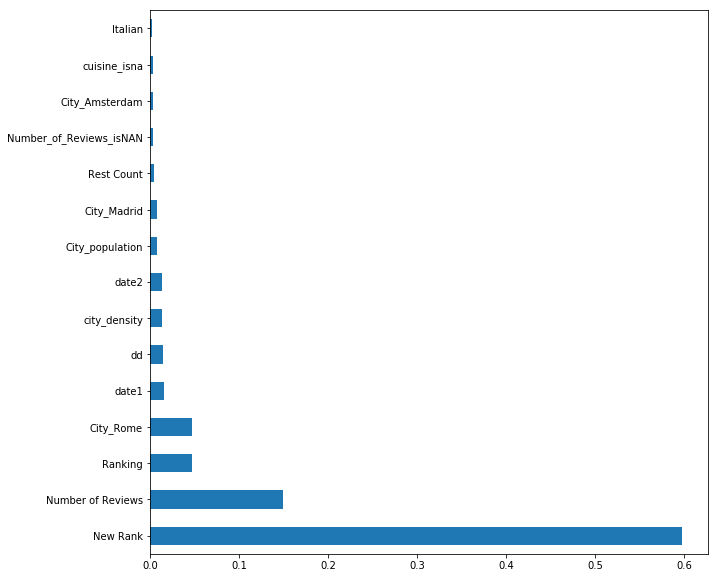

In [56]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [57]:
test_data.sample(10)

,Ranking,Number of Reviews,Rating,Number_of_Reviews_isNAN,City_population,city_density,Rest Count,New Rank,City_Amsterdam,City_Athens,...,Swiss,Thai,Turkish,VeganOptions,VegetarianFriendly,Vietnamese,WineBar,date1,date2,dd
1968,1539.0,22.0,0.0,0,505526,4883,1647,0.934426,0,0,...,0,0,0,0,0,0,0,51,482,431
8675,3105.0,2.0,0.0,0,505526,4883,1647,1.885246,0,0,...,0,0,0,0,0,0,0,0,0,0
5698,442.0,244.0,0.0,0,872757,4908,1372,0.322157,1,0,...,0,0,0,0,0,0,0,81,83,2
7094,1413.0,251.0,0.0,0,2148327,20781,6108,0.231336,0,0,...,0,0,0,0,1,0,0,279,349,70
5387,11148.0,60.0,0.0,0,2148327,20781,6108,1.825147,0,0,...,0,0,0,0,0,0,0,655,3582,2927
6787,6871.0,4.0,0.0,0,2148327,20781,6108,1.124918,0,0,...,0,0,0,0,0,0,0,0,0,0
1924,5638.0,94.0,0.0,0,8908081,5173,7193,0.783818,0,0,...,0,0,0,0,1,0,0,155,176,21
833,1118.0,106.0,0.0,0,179277,5384,1314,0.850837,0,0,...,0,0,0,0,0,0,0,230,140,-90
7075,6843.0,43.0,0.0,0,8908081,5173,7193,0.951342,0,0,...,0,0,0,0,0,0,0,291,380,89
980,7724.0,29.0,0.0,0,2148327,20781,6108,1.264571,0,0,...,0,0,0,0,0,0,0,404,1300,896


In [58]:
test_data = test_data.drop(['Rating'], axis=1)

In [59]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [60]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [61]:
predict_submission

array([3.015, 4.195, 4.47 , ..., 3.05 , 4.5  , 4.16 ])

In [62]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.015
1,id_1,4.195
2,id_2,4.470
3,id_3,4.355
4,id_4,4.465
5,id_5,4.455
6,id_6,2.680
7,id_7,2.250
8,id_8,4.115
9,id_9,4.675


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
